# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

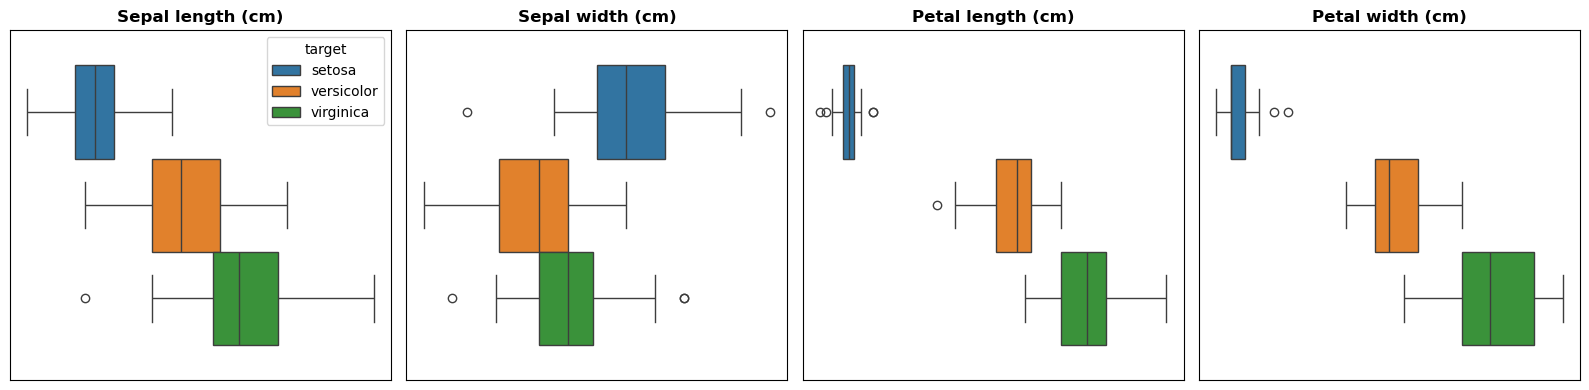

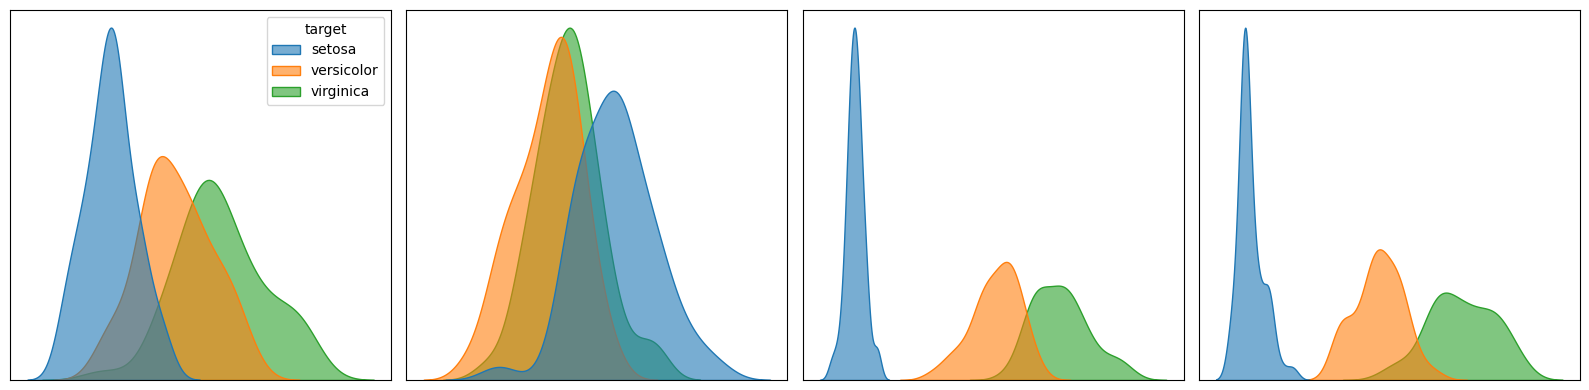

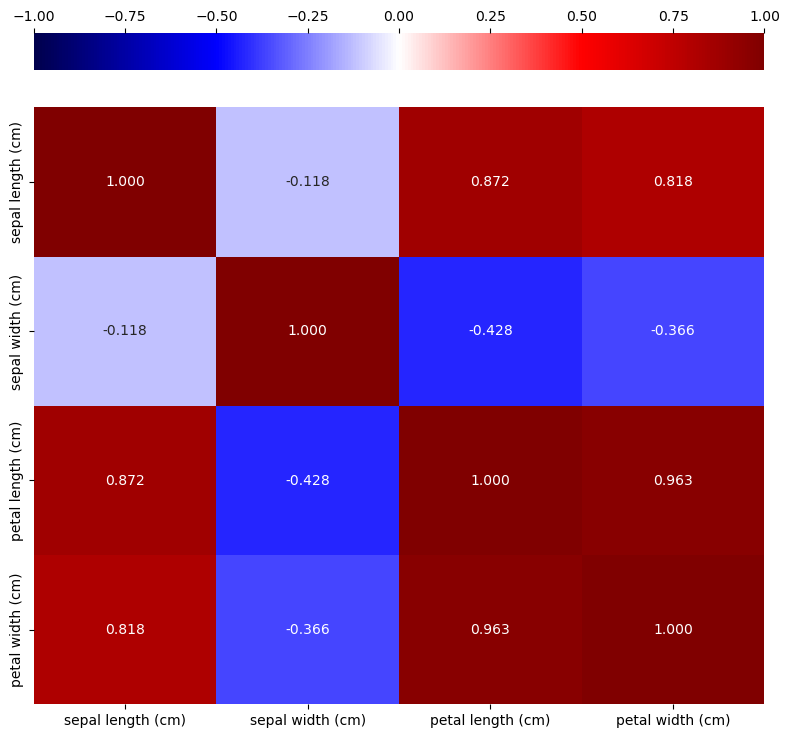

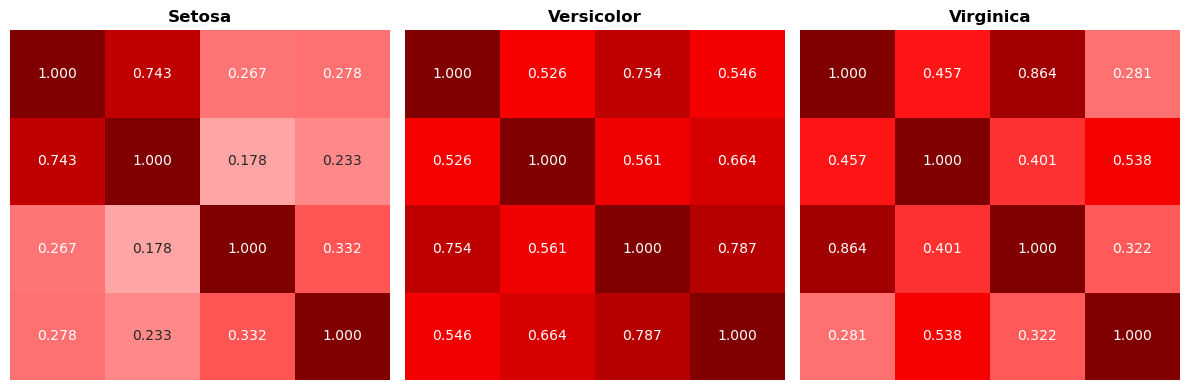

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.731300,2.943424,-0.035812,0.337717,setosa
1,4.252268,3.947391,0.486017,-1.458840,setosa
2,5.587227,4.600773,1.220767,0.306000,setosa
3,4.134959,4.359312,3.493431,0.040876,setosa
4,4.601519,4.164337,1.019016,-0.944431,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.047      5.964   
     sepal width (cm)   3.428      2.770     2.974     3.494      2.587   
     petal length (cm)  1.462      4.260     5.552     1.615      4.193   
     petal width (cm)   0.246      1.326     2.026    -0.042      1.491   
STD  sepal length (cm)  0.352      0.516     0.636     1.078      1.271   
     sepal width (cm)   0.379      0.314     0.322     1.097      1.051   
     petal length (cm)  0.174      0.470     0.552     1.121      1.264   
     petal width (cm)   0.105      0.198     0.275     1.076      1.036   
MIN  sepal length (cm)  4.300      4.900     4.900     2.870      3.400   
     sepal width (cm)   2.300      2.000     2.200     1.236      0.503   
     petal length (cm)  1.000      3.000     4.500    -0.327      1.219   
     petal width (cm)   0.100      1.000     1.400    -2.933     -1.279   
MAX  sepal length (cm)  5.800      7.000     7.900     7.850      8.657   
     sepal width (cm)   4.400      3.400     3.800     6.433      5.471   
     petal length (cm)  1.900      5.100     6.900     4.577      6.579   
     petal width (cm)   0.600      1.800     2.500     2.414      3.807   
SKEW sepal length (cm)  0.116      0.102     0.114     0.089     -0.190   
     sepal width (cm)   0.040     -0.352     0.355     0.004      0.067   
     petal length (cm)  0.103     -0.588     0.533     0.455      0.042   
     petal width (cm)   1.216     -0.030    -0.126     0.014     -0.406   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.299     -0.555   
     sepal width (cm)   0.744     -0.448     0.520     0.002     -0.060   
     petal length (cm)  0.805     -0.074    -0.256    -0.258     -0.590   
     petal width (cm)   1.434     -0.488    -0.661     0.302      0.094   
IQR  sepal length (cm)  0.400      0.700     0.675     1.535      1.575   
     sepal width (cm)   0.475      0.475     0.375     1.415      1.471   
     petal length (cm)  0.175      0.600     0.775     1.455      1.856   
     petal width (cm)   0.100      0.300     0.500     1.275      1.384   

                                  
                       virginica  
MEAN sepal length (cm)     6.425  
     sepal width (cm)      3.123  
     petal length (cm)     5.844  
     petal width (cm)      1.864  
STD  sepal length (cm)     1.155  
     sepal width (cm)      0.961  
     petal length (cm)     1.094  
     petal width (cm)      0.915  
MIN  sepal length (cm)     2.986  
     sepal width (cm)      1.012  
     petal length (cm)     3.155  
     petal width (cm)     -0.220  
MAX  sepal length (cm)     8.525  
     sepal width (cm)      5.309  
     petal length (cm)     7.838  
     petal width (cm)      3.795  
SKEW sepal length (cm)    -0.400  
     sepal width (cm)     -0.076  
     petal length (cm)    -0.323  
     petal width (cm)      0.029  
KURT sepal length (cm)     0.115  
     sepal width (cm)     -0.400  
     petal length (cm)    -0.352  
     petal width (cm)     -0.158  
IQR  sepal length (cm)     1.602  
     sepal width (cm)      1.200  
     petal length (cm)     1.475  
     petal width (cm)      1.192

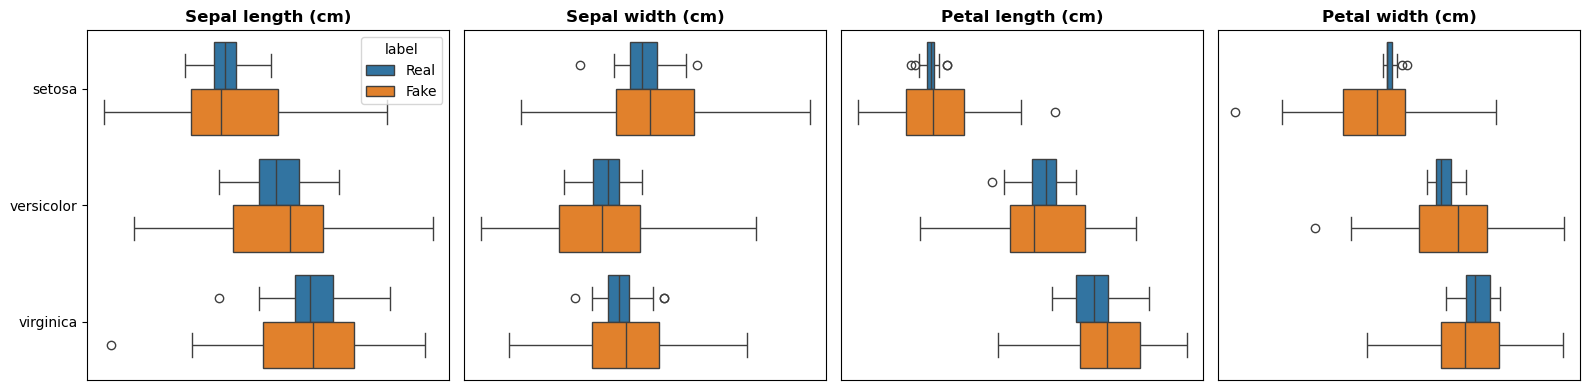

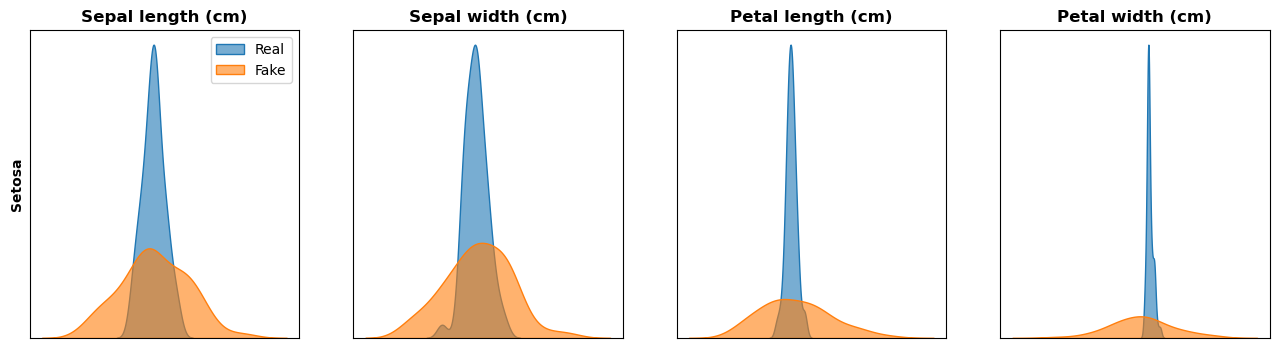

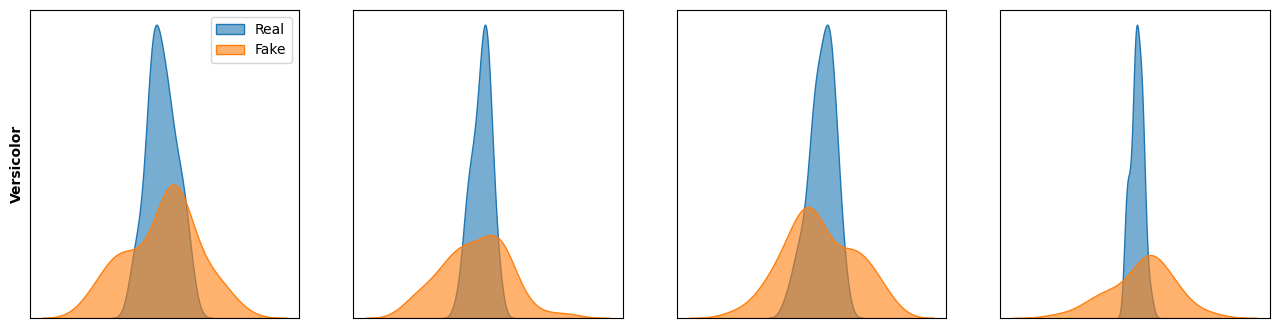

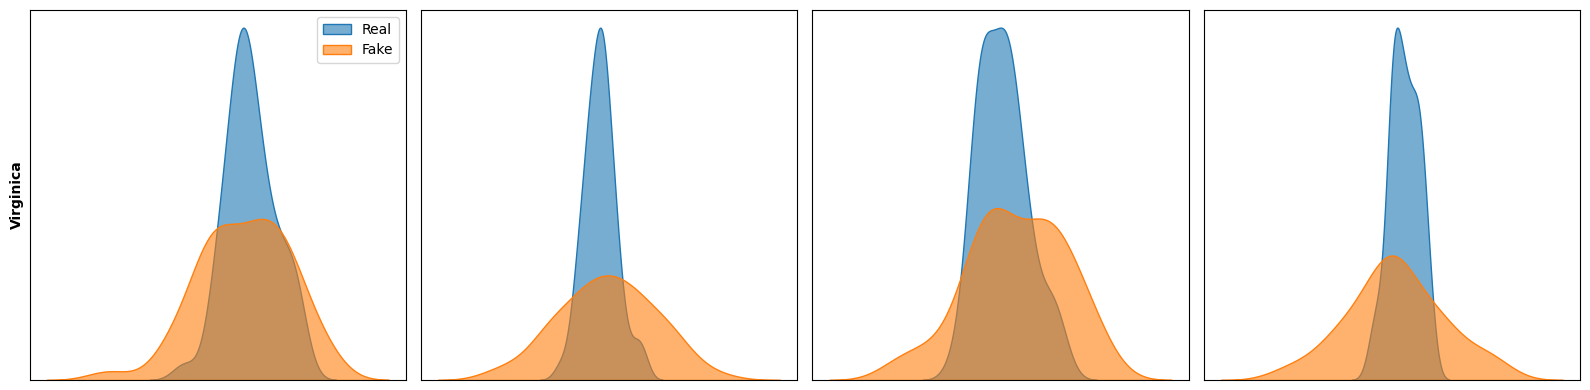

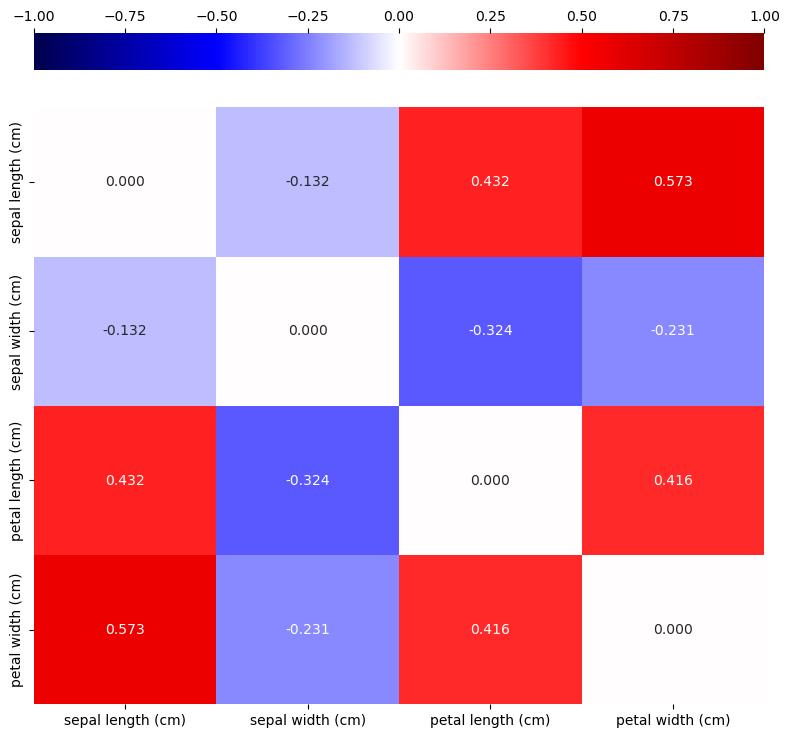

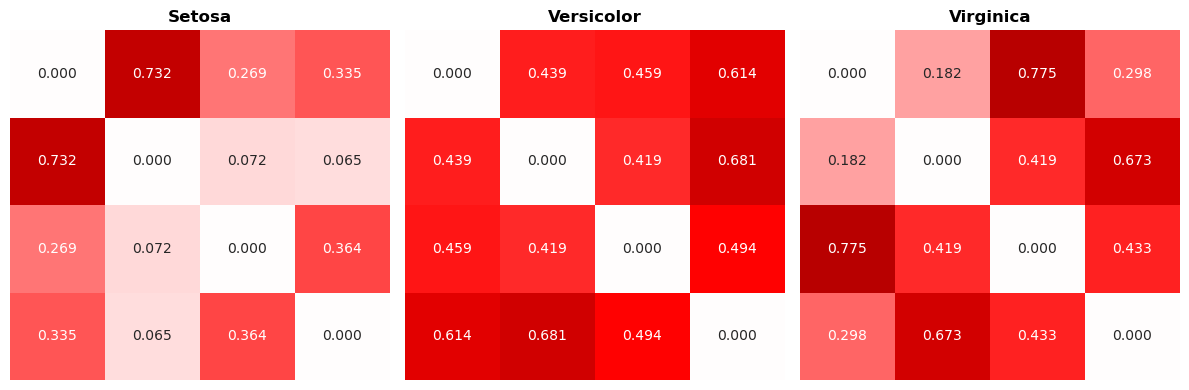

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    

vae = ConditionalVAE(input_dim = 4, latent_dim = 4, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])


Now let's build the GANs net.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

gen = Generator(input_dim = 4, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 4), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')
print(f'Disc has {sum(p.numel() for p in disc.parameters())} parameters')

VAE has 1724 parameters
Gen has 861 parameters
Disc has 714 parameters


We can now train the simpliest Conditional VAE.

In [15]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()

z = torch.randn(150, 4)

In [16]:
for epoch in tqdm(range(1, 501), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for data, label in real_vae_dataloader:
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 50 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/500 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 50/500 | Loss: 0.3144
MEAN: [-0.01   0.021 -0.086 -0.053]
STD:  [0.283 0.428 0.229 0.23 ]
MIN:  [-0.9   -1.727 -0.584 -0.461]
MAX:  [1.619 2.248 0.844 0.779]
SKEW: [ 0.675 -0.337  0.193  0.241]
KURT: [0.934 1.67  0.11  0.173]

Epoch 100/500 | Loss: 0.2989
MEAN: [-0.     0.017 -0.078 -0.039]
STD:  [0.232 0.363 0.193 0.197]
MIN:  [-0.877 -1.645 -0.57  -0.449]
MAX:  [1.564 2.187 0.804 0.729]
SKEW: [ 0.488 -0.148  0.072  0.096]
KURT: [0.931 1.667 0.111 0.171]

Epoch 150/500 | Loss: 0.2959
MEAN: [-0.001  0.007 -0.084 -0.048]
STD:  [0.228 0.371 0.187 0.19 ]
MIN:  [-0.876 -1.696 -0.569 -0.448]
MAX:  [1.544 2.188 0.795 0.72 ]
SKEW: [ 0.477 -0.113  0.073  0.107]
KURT: [0.928 1.659 0.107 0.167]

Epoch 200/500 | Loss: 0.2877
MEAN: [-0.014 -0.005 -0.095 -0.061]
STD:  [0.223 0.357 0.181 0.185]
MIN:  [-0.876 -1.702 -0.568 -0.448]
MAX:  [1.544 2.169 0.795 0.718]
SKEW: [ 0.515 -0.107  0.098  0.139]
KURT: [0.931 1.671 0.108 0.168]

Epoch 250/500 | Loss: 0.2900
MEAN: [-0.013  0.006 -0.095 -0.056]

In [17]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

In [18]:
utils.describe_data(real_iris, 'target', vae_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.023      5.951   
     sepal width (cm)   3.428      2.770     2.974     3.428      2.768   
     petal length (cm)  1.462      4.260     5.552     2.000      4.306   
     petal width (cm)   0.246      1.326     2.026     0.440      1.351   
STD  sepal length (cm)  0.352      0.516     0.636     0.002      0.026   
     sepal width (cm)   0.379      0.314     0.322     0.012      0.011   
     petal length (cm)  0.174      0.470     0.552     0.001      0.063   
     petal width (cm)   0.105      0.198     0.275     0.000      0.033   
MIN  sepal length (cm)  4.300      4.900     4.900     5.021      5.893   
     sepal width (cm)   2.300      2.000     2.200     3.358      2.747   
     petal length (cm)  1.000      3.000     4.500     1.999      4.191   
     petal width (cm)   0.100      1.000     1.400     0.440      1.293   
MAX  sepal length (cm)  5.800      7.000     7.900     5.034      6.004   
     sepal width (cm)   4.400      3.400     3.800     3.439      2.805   
     petal length (cm)  1.900      5.100     6.900     2.003      4.432   
     petal width (cm)   0.600      1.800     2.500     0.441      1.420   
SKEW sepal length (cm)  0.116      0.102     0.114     3.714      0.079   
     sepal width (cm)   0.040     -0.352     0.355    -4.090      0.857   
     petal length (cm)  0.103     -0.588     0.533     3.492      0.283   
     petal width (cm)   1.216     -0.030    -0.126     3.582      0.317   
KURT sepal length (cm) -0.346     -0.599    -0.088    17.622     -0.472   
     sepal width (cm)   0.744     -0.448     0.520    20.524      1.171   
     petal length (cm)  0.805     -0.074    -0.256    15.086     -0.955   
     petal width (cm)   1.434     -0.488    -0.661    15.084     -0.826   
IQR  sepal length (cm)  0.400      0.700     0.675     0.001      0.037   
     sepal width (cm)   0.475      0.475     0.375     0.009      0.013   
     petal length (cm)  0.175      0.600     0.775     0.000      0.100   
     petal width (cm)   0.100      0.300     0.500     0.000      0.053   

                                  
                       virginica  
MEAN sepal length (cm)     6.592  
     sepal width (cm)      2.979  
     petal length (cm)     5.498  
     petal width (cm)      1.955  
STD  sepal length (cm)     0.014  
     sepal width (cm)      0.020  
     petal length (cm)     0.008  
     petal width (cm)      0.002  
MIN  sepal length (cm)     6.567  
     sepal width (cm)      2.905  
     petal length (cm)     5.476  
     petal width (cm)      1.949  
MAX  sepal length (cm)     6.619  
     sepal width (cm)      3.007  
     petal length (cm)     5.511  
     petal width (cm)      1.958  
SKEW sepal length (cm)    -0.012  
     sepal width (cm)     -1.957  
     petal length (cm)    -0.709  
     petal width (cm)     -1.248  
KURT sepal length (cm)    -0.765  
     sepal width (cm)      4.633  
     petal length (cm)     0.110  
     petal width (cm)      1.764  
IQR  sepal length (cm)     0.020  
     sepal width (cm)      0.011  
     petal length (cm)     0.010  
     petal width (cm)      0.002

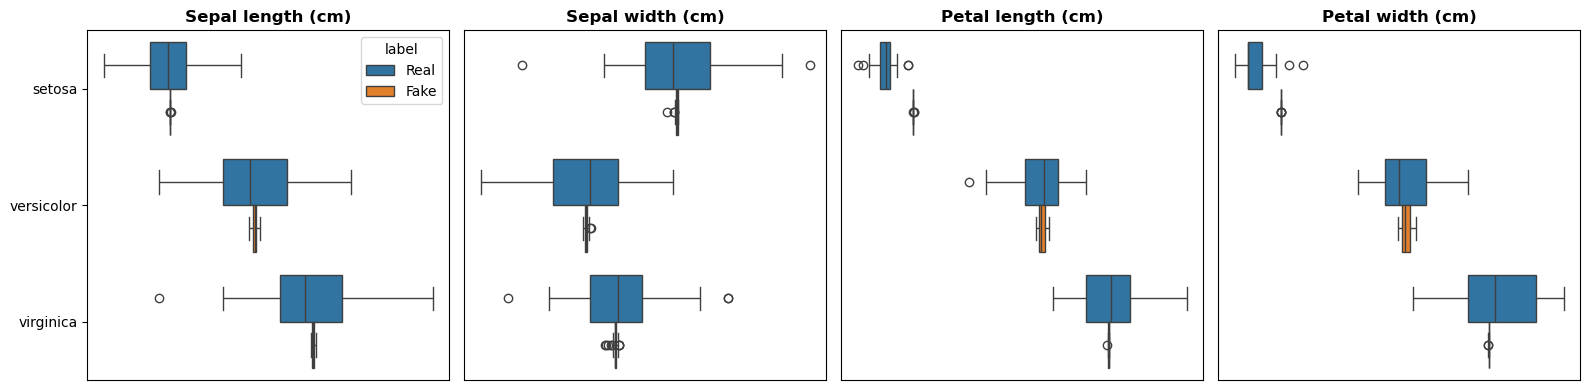

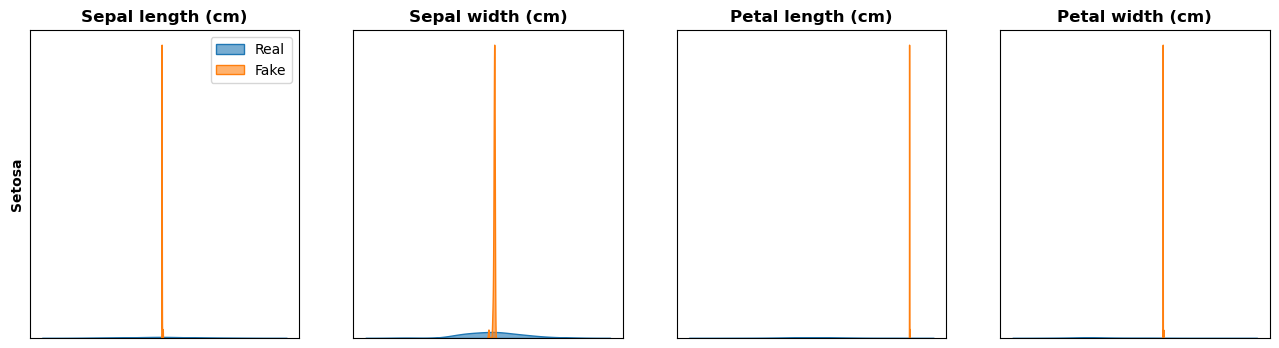

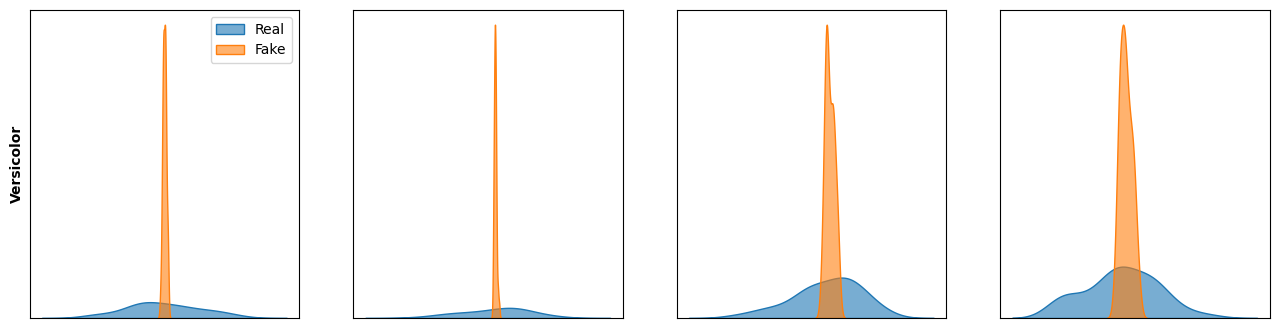

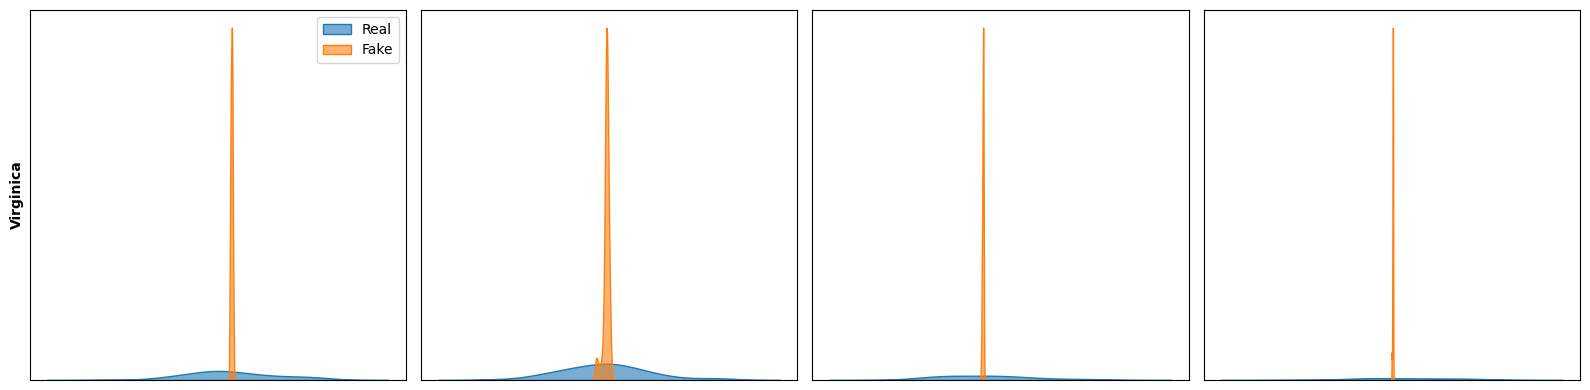

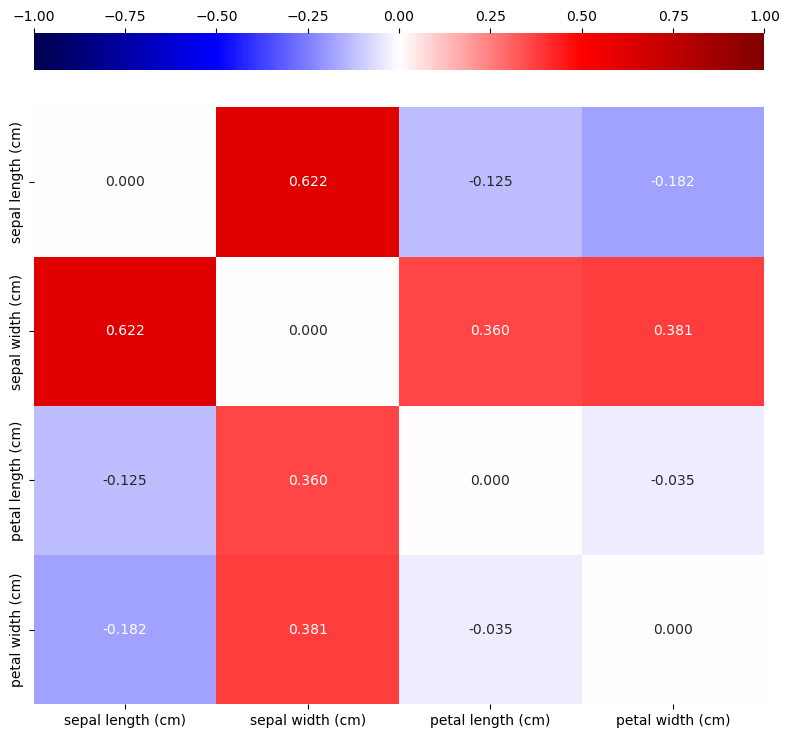

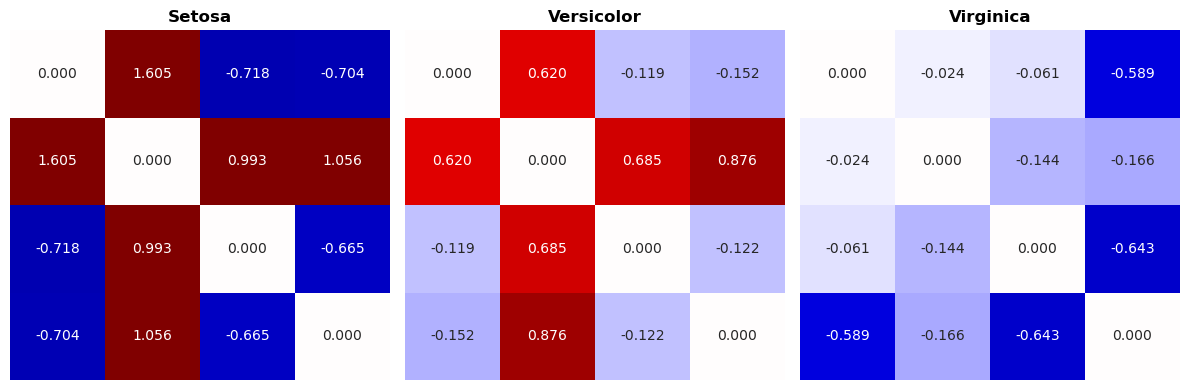

In [19]:
utils.plot_data(real_iris, 'target', vae_df)

Let's train the Conditional GAN.

In [20]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [21]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 4)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 50 == 0 or epoch == 500:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6942 | GLoss 0.6984
MEAN: [ 0.404  0.447 -0.007  0.165]
STD:  [0.943 0.899 0.946 0.953]
MIN:  [-1.309 -1.649 -1.415 -1.168]
MAX:  [2.769 3.304 1.625 1.733]
SKEW: [ 0.65   0.647 -0.502 -0.187]
KURT: [-0.398 -0.152 -1.413 -1.456]

Epoch 50/500 | DLoss: 0.5973 | GLoss 0.8484
MEAN: [-0.003  0.081  0.692  0.547]
STD:  [0.463 0.887 0.426 0.603]
MIN:  [-0.882 -2.015  0.592  0.069]
MAX:  [1.713 2.899 1.813 1.826]
SKEW: [0.74  0.506 0.559 0.707]
KURT: [ 0.846  0.438 -0.651 -0.439]

Epoch 100/500 | DLoss: 0.6321 | GLoss 0.8267
MEAN: [-0.415 -0.265 -0.349  0.655]
STD:  [0.242 0.537 0.348 0.488]
MIN:  [-1.182 -2.157 -0.818  0.058]
MAX:  [0.613 2.038 0.39  1.445]
SKEW: [ 0.686 -0.352  0.256  0.126]
KURT: [0.77  1.631 0.015 0.074]

Epoch 150/500 | DLoss: 0.7876 | GLoss 0.6261
MEAN: [-0.503 -0.527 -0.549  0.442]
STD:  [0.036 0.563 0.087 0.304]
MIN:  [-0.936 -2.242 -0.778  0.087]
MAX:  [ 0.684  1.688 -0.058  1.024]
SKEW: [0.961 0.358 0.317 0.19 ]
KURT: [0.914 1.495 0.09  0.131]

In [22]:
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

In [23]:
utils.describe_data(real_iris, 'target', gan_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     4.972      5.807   
     sepal width (cm)   3.428      2.770     2.974     3.280      2.609   
     petal length (cm)  1.462      4.260     5.552     1.871      4.056   
     petal width (cm)   0.246      1.326     2.026     0.233      0.889   
STD  sepal length (cm)  0.352      0.516     0.636     0.074      0.263   
     sepal width (cm)   0.379      0.314     0.322     0.199      0.323   
     petal length (cm)  0.174      0.470     0.552     0.215      0.437   
     petal width (cm)   0.105      0.198     0.275     0.163      0.331   
MIN  sepal length (cm)  4.300      4.900     4.900     4.853      5.393   
     sepal width (cm)   2.300      2.000     2.200     2.841      1.989   
     petal length (cm)  1.000      3.000     4.500     1.560      3.459   
     petal width (cm)   0.100      1.000     1.400    -0.116      0.199   
MAX  sepal length (cm)  5.800      7.000     7.900     5.170      6.946   
     sepal width (cm)   4.400      3.400     3.800     3.749      3.719   
     petal length (cm)  1.900      5.100     6.900     2.330      6.018   
     petal width (cm)   0.600      1.800     2.500     0.492      1.915   
SKEW sepal length (cm)  0.116      0.102     0.114     0.444      2.146   
     sepal width (cm)   0.040     -0.352     0.355     0.404      1.072   
     petal length (cm)  0.103     -0.588     0.533     0.413      2.428   
     petal width (cm)   1.216     -0.030    -0.126    -0.348      0.723   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.230      6.660   
     sepal width (cm)   0.744     -0.448     0.520    -0.236      1.883   
     petal length (cm)  0.805     -0.074    -0.256    -0.873      7.481   
     petal width (cm)   1.434     -0.488    -0.661    -0.851      0.970   
IQR  sepal length (cm)  0.400      0.700     0.675     0.089      0.233   
     sepal width (cm)   0.475      0.475     0.375     0.264      0.378   
     petal length (cm)  0.175      0.600     0.775     0.313      0.350   
     petal width (cm)   0.100      0.300     0.500     0.228      0.352   

                                  
                       virginica  
MEAN sepal length (cm)     6.342  
     sepal width (cm)      3.089  
     petal length (cm)     5.146  
     petal width (cm)      1.485  
STD  sepal length (cm)     0.495  
     sepal width (cm)      0.493  
     petal length (cm)     0.876  
     petal width (cm)      0.432  
MIN  sepal length (cm)     5.748  
     sepal width (cm)      2.309  
     petal length (cm)     3.883  
     petal width (cm)      0.707  
MAX  sepal length (cm)     7.765  
     sepal width (cm)      4.343  
     petal length (cm)     7.183  
     petal width (cm)      2.270  
SKEW sepal length (cm)     1.214  
     sepal width (cm)      0.599  
     petal length (cm)     0.528  
     petal width (cm)     -0.129  
KURT sepal length (cm)     0.915  
     sepal width (cm)     -0.180  
     petal length (cm)    -0.302  
     petal width (cm)     -0.953  
IQR  sepal length (cm)     0.598  
     sepal width (cm)      0.686  
     petal length (cm)     1.143  
     petal width (cm)      0.691

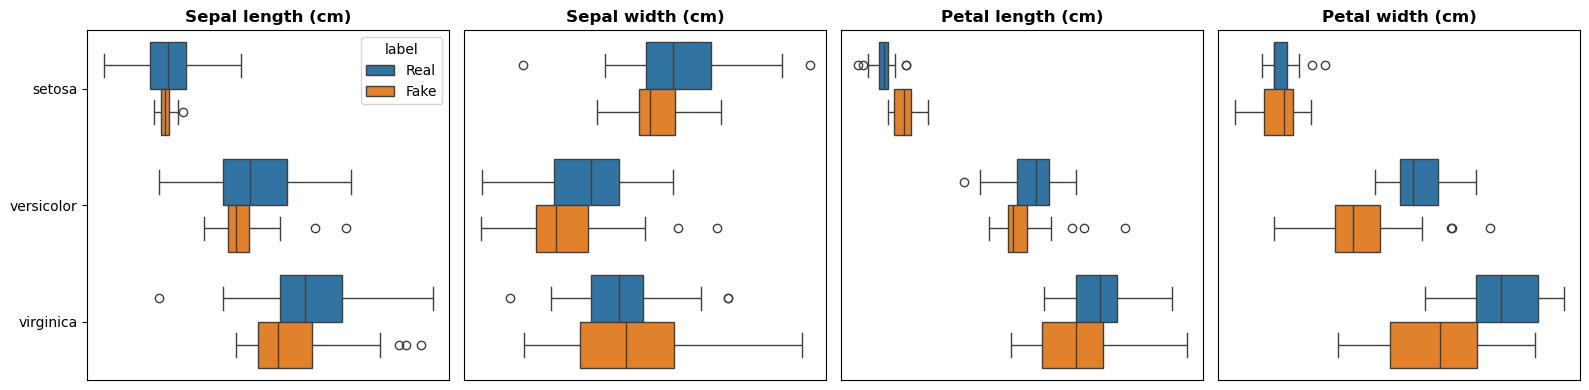

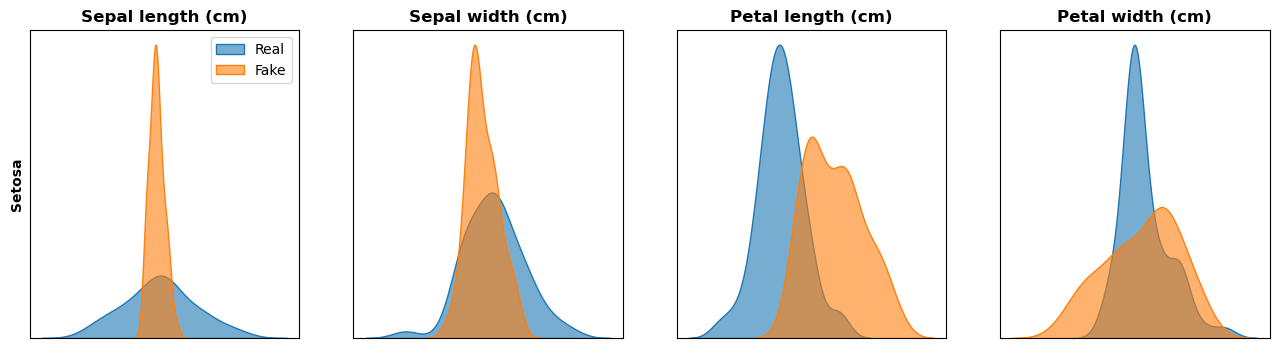

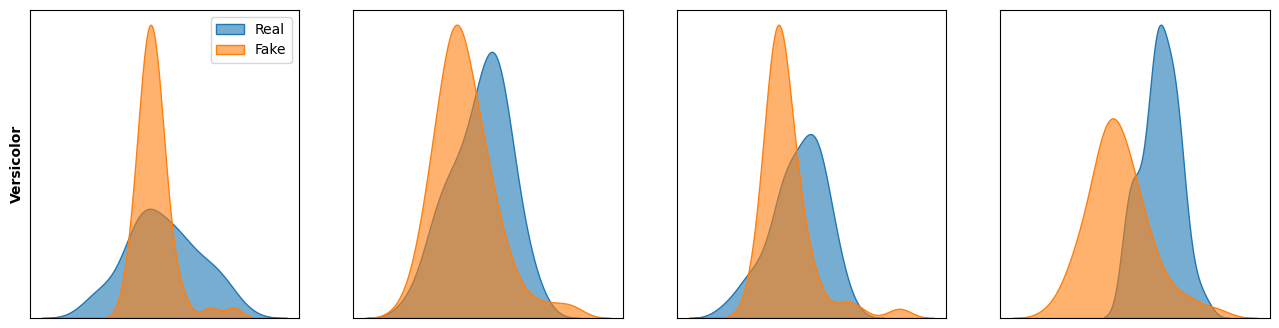

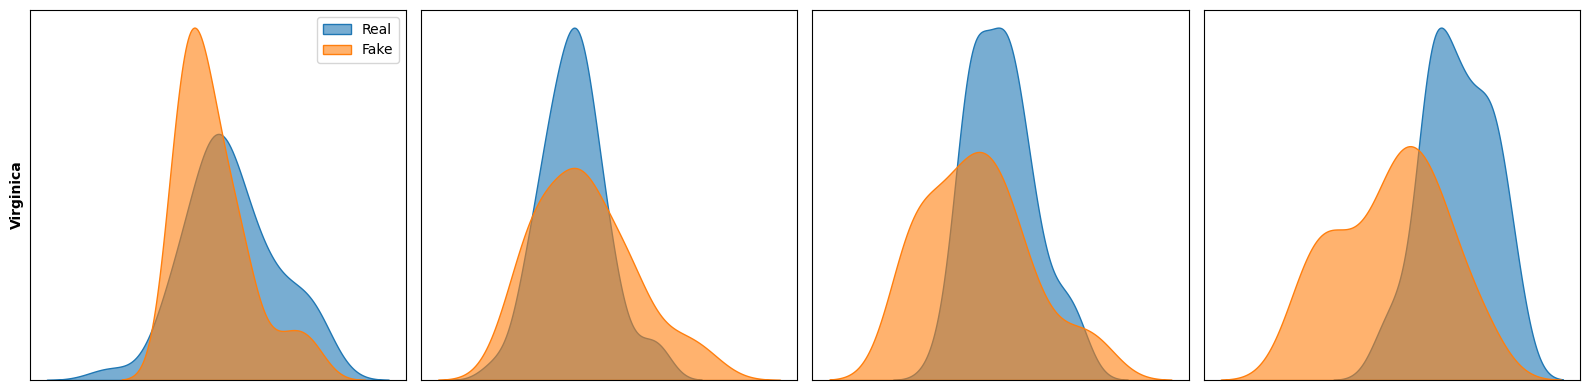

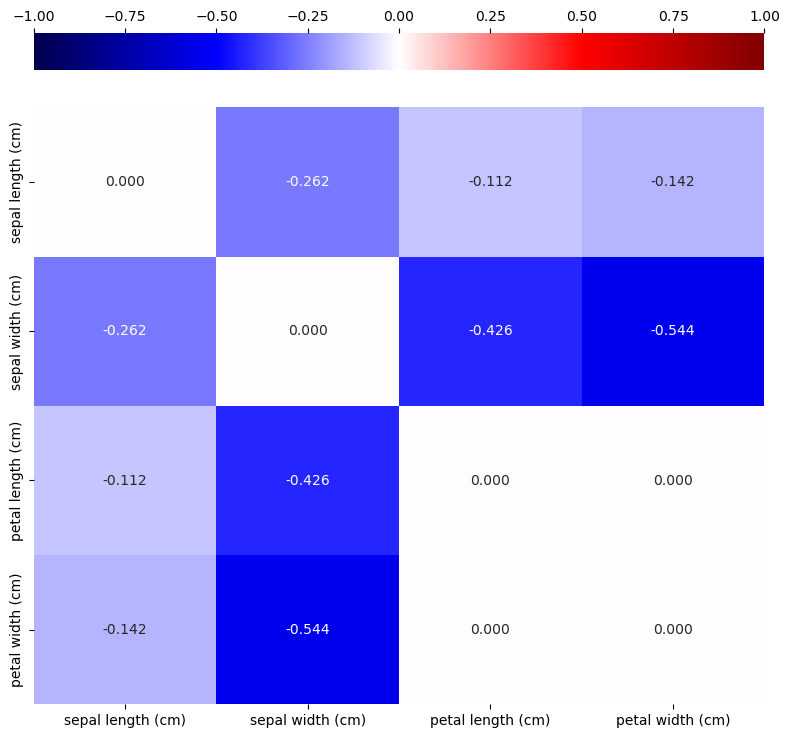

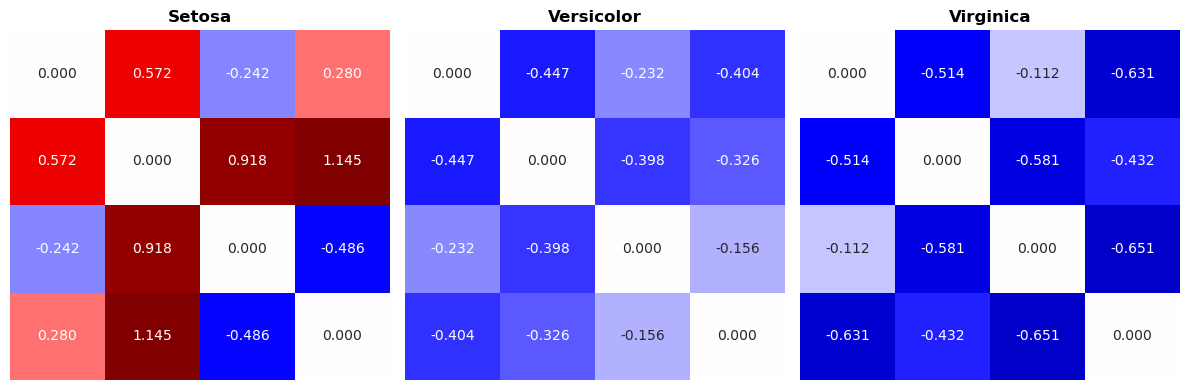

In [24]:
utils.plot_data(real_iris, 'target', gan_df)

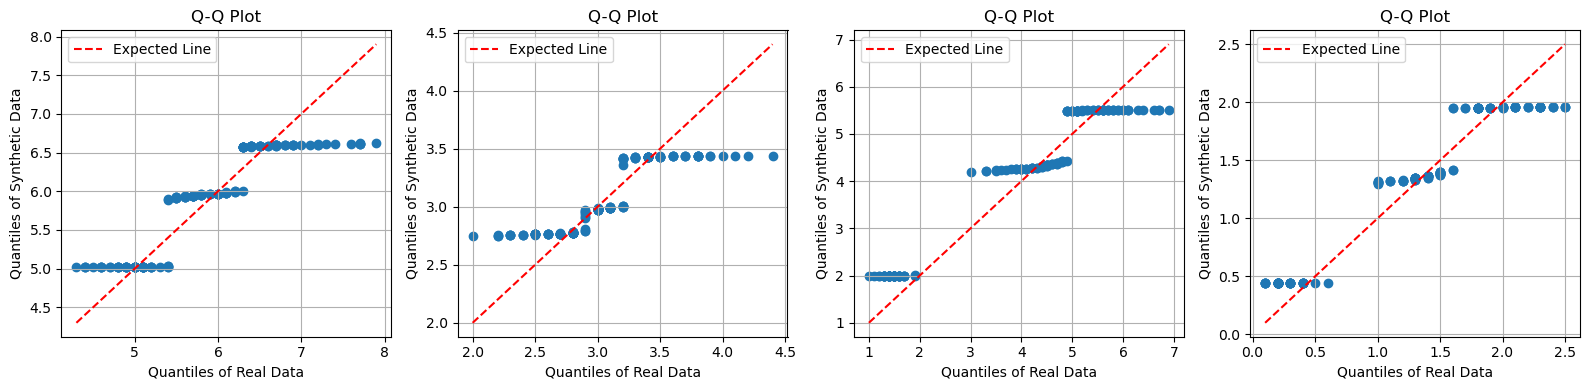

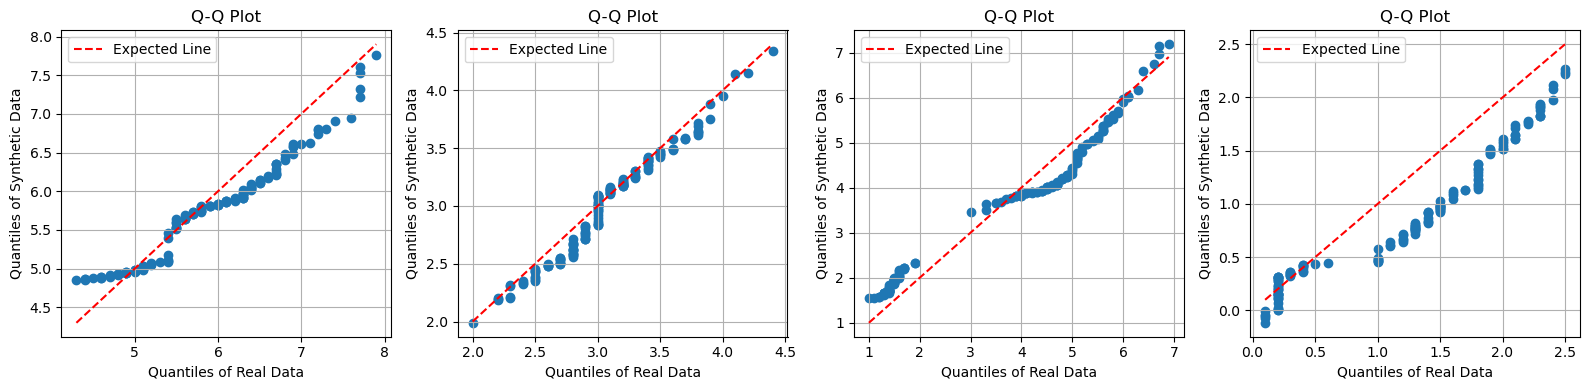

In [25]:
utils.plot_quantiles(real_iris, vae_df)
utils.plot_quantiles(real_iris, gan_df)

The performance of the models is clear: using Q-Q plots we see that the data generated with the simpler GAN show better overlap with the actual data. We will follow this path.

## Conditional Generative Adversarial Network

In this section, we focus on refining the GAN architecture to maximize its performance in generating synthetic data that closely resembles the real dataset. Our aim is to improve the overlap between the distributions of generated and real data while maintaining computational efficiency. The resulting model will form the basis for subsequent evaluations and applications.

The strating point is a model with 861 parameters. We'll build other 2 bigger versions to prove out which is the best.

In [26]:
# Smallest GAN

class Generator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Medium GAN

class Generator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Big GAN

class Generator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
    
small_gan_gen = Generator1(input_dim = 4, num_classes = 3)
small_gan_disc = Discriminator1(input_dim = 4, num_classes = 3)

med_gan_gen = Generator2(input_dim = 4, num_classes = 3)
med_gan_disc = Discriminator2(input_dim = 4, num_classes = 3)

big_gan_gen = Generator3(input_dim = 4, num_classes = 3)
big_gan_disc = Discriminator3(input_dim = 4, num_classes = 3)

small_gan = {'Generator':small_gan_gen, 'Discriminator':small_gan_disc}

med_gan = {'Generator':med_gan_gen, 'Discriminator':med_gan_disc}

big_gan = {'Generator':big_gan_gen, 'Discriminator':big_gan_disc}

In [27]:
for size in [small_gan, med_gan, big_gan]:
    for model in size:
        print(f'{model} parameters: {sum(p.numel() for p in size[model].parameters())/1000}k')

Generator parameters: 0.861k
Discriminator parameters: 0.714k
Generator parameters: 3.197k
Discriminator parameters: 2.858k
Generator parameters: 11.965k
Discriminator parameters: 11.242k


The 3 models have a very different number of parameters. Next step is to set the optimized ones and start training.

In [28]:
small_gan['Generator optimizer'] = torch.optim.Adam(small_gan_gen.parameters(), lr = 1e-3)
small_gan['Discriminator optimizer'] = torch.optim.Adam(small_gan_disc.parameters(), lr = 1e-3)

med_gan['Generator optimizer'] = torch.optim.Adam(med_gan_gen.parameters(), lr = 1e-3)
med_gan['Discriminator optimizer'] = torch.optim.Adam(med_gan_disc.parameters(), lr = 1e-3)

big_gan['Generator optimizer'] = torch.optim.Adam(big_gan_gen.parameters(), lr = 1e-3)
big_gan['Discriminator optimizer'] = torch.optim.Adam(big_gan_disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [29]:
for idx, size in enumerate([small_gan, med_gan, big_gan]):
    
    for epoch in tqdm(range(501), desc = f'Training Conditional GAN {idx + 1}'):
        
        gen = size['Generator']
        disc = size['Discriminator']
        g_opt = size['Generator optimizer']
        d_opt = size['Discriminator optimizer']
        
        gen_epoch_loss = 0
        disc_epoch_loss = 0
    
        disc.train()
        gen.train()
        
        for data, labels in real_gan_dataloader:
            
            real_data = data
            real_labels = torch.ones(real_data.shape[0], 1)
        
            train_z = torch.randn(real_data.shape[0], 4)
            fake_data = gen(train_z, labels)
            fake_labels = torch.zeros(real_data.shape[0], 1)
        
            disc.zero_grad()
            
            real_loss = criterion(disc(real_data, labels), real_labels)
            fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            disc_epoch_loss += d_loss.item()
            d_loss.backward()
        
            d_opt.step()
        
            gen.zero_grad()
        
            gen_labels = torch.ones(real_data.shape[0], 1)
        
            g_loss = criterion(disc(fake_data, labels), gen_labels)
            gen_epoch_loss += g_loss.item()
            g_loss.backward()
        
            g_opt.step()
            
        g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
        d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
        
        if epoch % 50 == 0 or epoch == 500:
        
            print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
            with torch.no_grad():
                gen.eval()
                gen_z = gen(z, real_gan_dataloader.dataset.label)
                utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN 1:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7026 | GLoss 0.7170
MEAN: [ 0.127  0.005 -0.052  0.255]
STD:  [0.946 0.929 0.95  0.958]
MIN:  [-1.463 -2.23  -1.411 -0.96 ]
MAX:  [2.516 2.769 1.667 1.894]
SKEW: [ 1.791 -0.428  1.312  1.539]
KURT: [-4.448 -1.862 -4.587 -6.005]

Epoch 50/500 | DLoss: 0.6741 | GLoss 0.6164
MEAN: [0.862 0.27  0.909 1.398]
STD:  [0.65  0.894 0.536 0.48 ]
MIN:  [ 0.503 -1.745  1.372  2.242]
MAX:  [2.869 3.205 2.09  2.417]
SKEW: [1.53  1.632 1.024 1.183]
KURT: [-2.197 -2.07  -3.337 -3.321]

Epoch 100/500 | DLoss: 0.7720 | GLoss 0.7664
MEAN: [ 0.696  1.498 -0.953 -0.787]
STD:  [-0.405 -0.445 -0.497 -0.188]
MIN:  [ 3.498  2.812  0.889 -0.029]
MAX:  [ 1.296  1.934 -2.087 -1.811]
SKEW: [ 1.111  0.396 -0.057 -0.141]
KURT: [-0.395  1.166 -0.378 -0.2  ]

Epoch 150/500 | DLoss: 0.6407 | GLoss 0.9067
MEAN: [-0.369 -0.172  0.436 -0.558]
STD:  [-0.17  -0.059 -0.006 -0.164]
MIN:  [-0.339 -1.352  0.738 -0.365]
MAX:  [ 0.133  0.964  1.239 -1.96 ]
SKEW: [ 0.72  -0.438  0.509 -0.471]
KURT: [ 0.735  

Training Conditional GAN 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6818 | GLoss 0.6496
MEAN: [0.216 0.127 0.211 0.029]
STD:  [0.977 0.982 0.98  0.985]
MIN:  [-1.597 -2.261 -1.279 -1.334]
MAX:  [2.583 3.163 1.939 1.709]
SKEW: [-0.746 -0.166  0.089  1.171]
KURT: [-3.986  0.318 -1.581 -4.195]

Epoch 50/500 | DLoss: 0.6312 | GLoss 1.1650
MEAN: [-0.418 -2.814  0.805 -0.699]
STD:  [-0.232  0.228 -0.318 -0.337]
MIN:  [-0.115 -4.067  2.254  0.367]
MAX:  [ 0.761 -2.683  1.456 -0.36 ]
SKEW: [ 0.94  -0.443  0.483  0.537]
KURT: [ 0.887 -0.637 -0.14   0.099]

Epoch 100/500 | DLoss: 0.6500 | GLoss 0.7206
MEAN: [-0.636  0.036  0.045  0.193]
STD:  [0.057 0.915 0.373 0.355]
MIN:  [-1.21  -2.244 -0.478  0.096]
MAX:  [0.156 2.896 0.751 1.115]
SKEW: [ 0.271 -0.071 -0.102  0.432]
KURT: [0.875 1.192 0.057 0.012]

Epoch 150/500 | DLoss: 0.5859 | GLoss 0.8759
MEAN: [-0.883  0.36  -0.813 -0.457]
STD:  [ 0.235  0.494 -0.272  0.41 ]
MIN:  [-1.811 -1.456 -0.562 -1.054]
MAX:  [ 0.264  2.647 -0.876  0.395]
SKEW: [ 0.262 -0.225  0.064  0.18 ]
KURT: [0.908 1.

Training Conditional GAN 3:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6892 | GLoss 0.6937
MEAN: [-0.126  0.146 -0.174  0.086]
STD:  [0.988 0.993 0.99  0.996]
MIN:  [-1.967 -2.264 -1.718 -1.335]
MAX:  [2.331 3.208 1.563 1.782]
SKEW: [ 0.494 -0.046 -1.098  0.267]
KURT: [ 0.437  0.354 -2.488 -1.337]

Epoch 50/500 | DLoss: 0.5211 | GLoss 1.8073
MEAN: [ 3.084 -0.748  1.584  2.908]
STD:  [-0.972  0.476 -0.127 -0.732]
MIN:  [ 6.175 -2.432  2.857  5.829]
MAX:  [2.781 1.012 1.763 2.157]
SKEW: [ 0.736 -0.115  0.154  0.325]
KURT: [ 0.313  1.042 -0.518 -0.46 ]

Epoch 100/500 | DLoss: 0.3748 | GLoss 2.2745
MEAN: [-0.519  1.376 -0.378 -0.34 ]
STD:  [0.726 0.383 0.943 0.789]
MIN:  [-2.017  0.308 -1.858 -1.506]
MAX:  [1.355 3.653 1.289 0.88 ]
SKEW: [-0.031  0.687 -0.499 -0.526]
KURT: [ 0.567  1.344 -0.124 -0.238]

Epoch 150/500 | DLoss: 1.4266 | GLoss 0.7976
MEAN: [ 1.382  4.141  3.149 -0.939]
STD:  [ 0.388 -0.877 -0.442  0.497]
MIN:  [ 1.852  8.763  6.859 -1.645]
MAX:  [ 2.79   4.363  2.398 -1.202]
SKEW: [ 1.651  1.728  0.769 -1.784]
KURT: [-3.4

Great! Now we can compare the results to choose the best architecture.

In [30]:
gen1_z = small_gan['Generator'](z, real_gan_dataloader.dataset.label)
gen2_z = med_gan['Generator'](z, real_gan_dataloader.dataset.label)
gen3_z = big_gan['Generator'](z, real_gan_dataloader.dataset.label)

In [31]:
gan1_df = pd.DataFrame(std_scl.inverse_transform(gen1_z.detach().numpy()))
gan1_df['target'] = y
gan1_df['target'] = gan1_df['target'].map({i: species[i] for i in range(len(species))})
gan1_df.columns = real_iris.columns

gan2_df = pd.DataFrame(std_scl.inverse_transform(gen2_z.detach().numpy()))
gan2_df['target'] = y
gan2_df['target'] = gan2_df['target'].map({i: species[i] for i in range(len(species))})
gan2_df.columns = real_iris.columns

gan3_df = pd.DataFrame(std_scl.inverse_transform(gen3_z.detach().numpy()))
gan3_df['target'] = y
gan3_df['target'] = gan3_df['target'].map({i: species[i] for i in range(len(species))})
gan3_df.columns = real_iris.columns

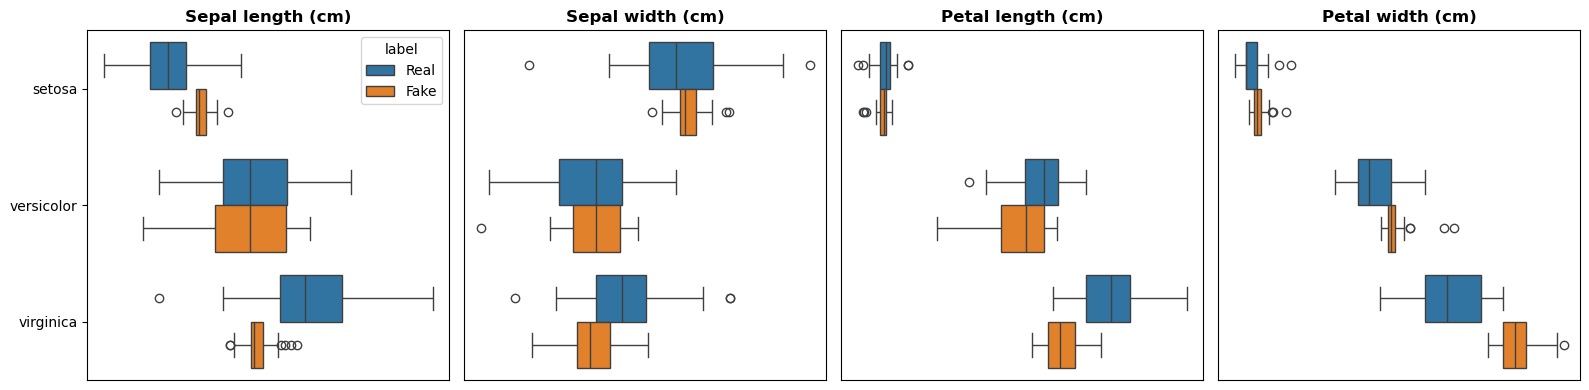

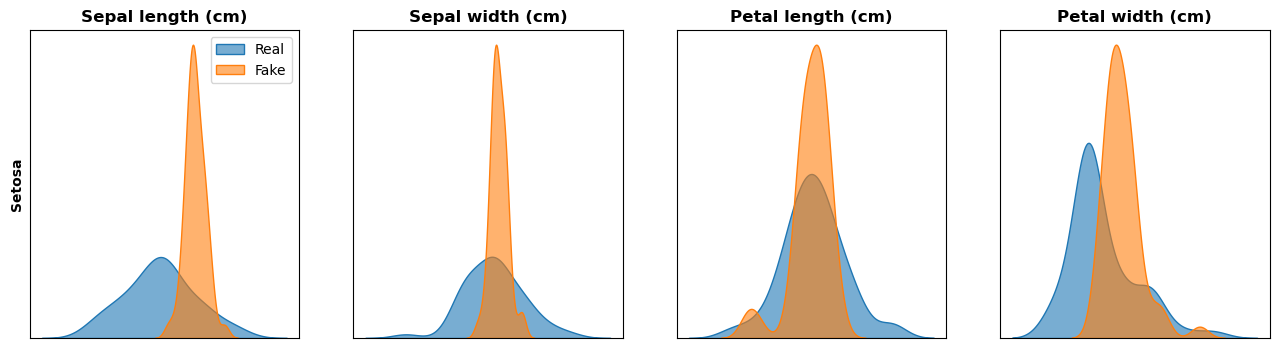

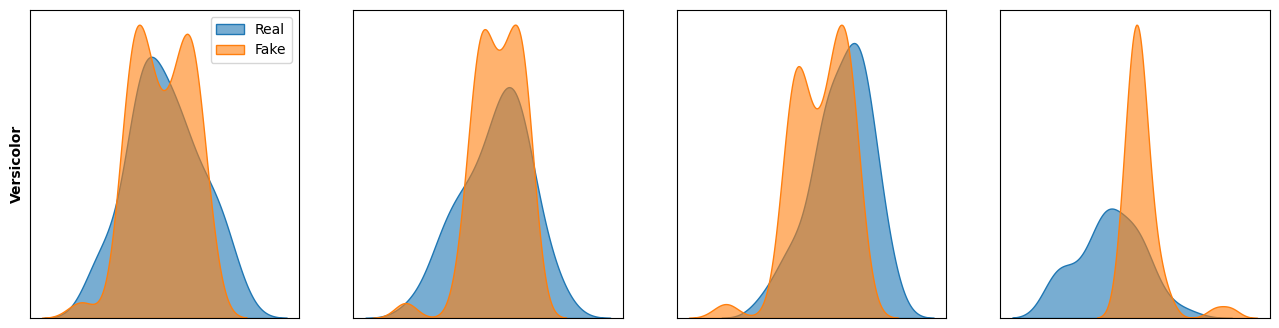

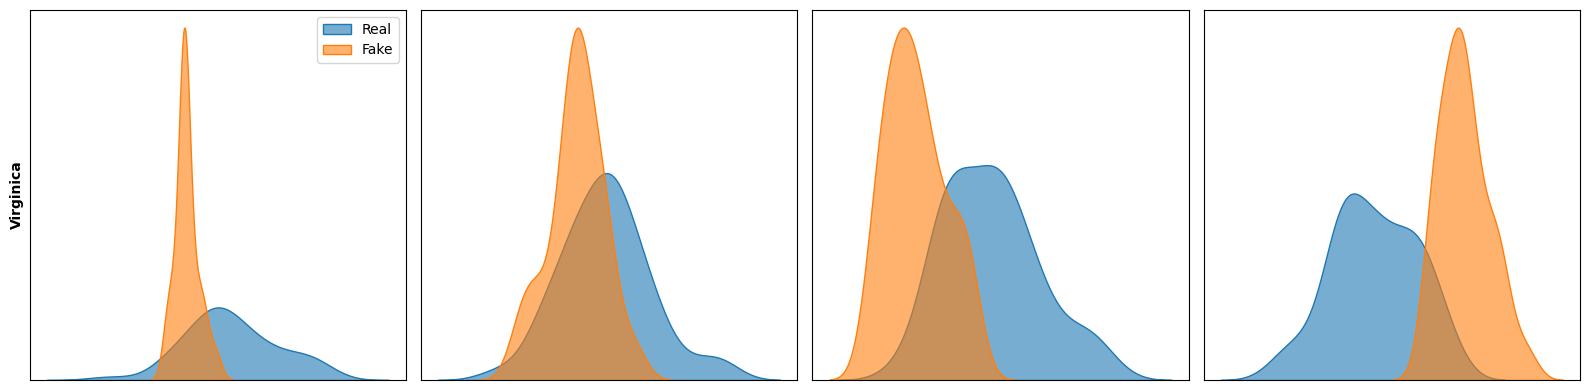

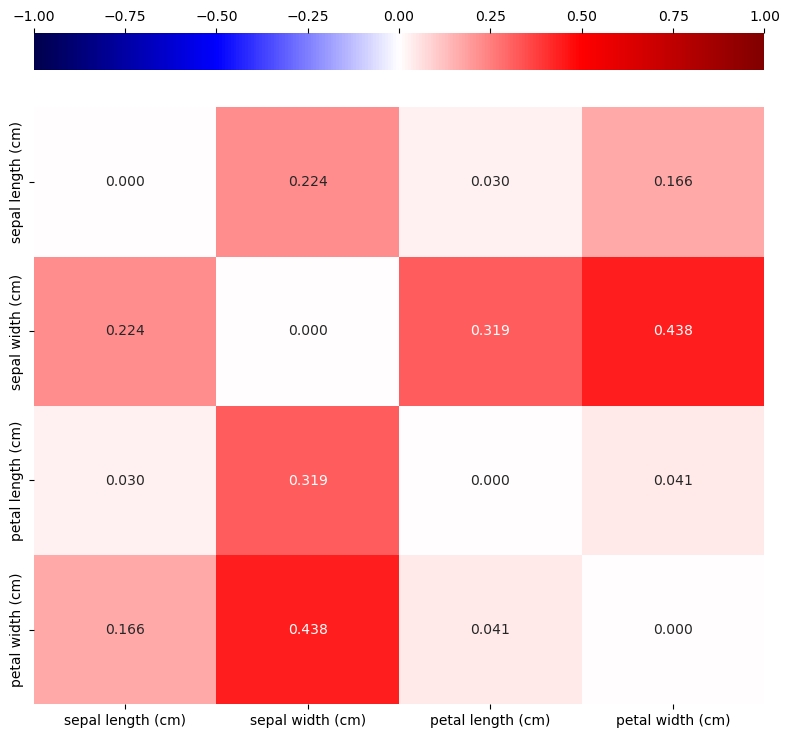

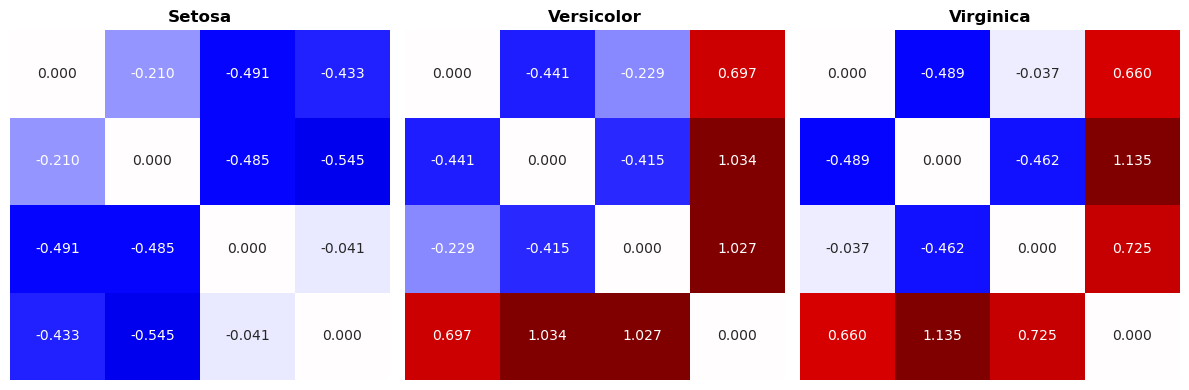

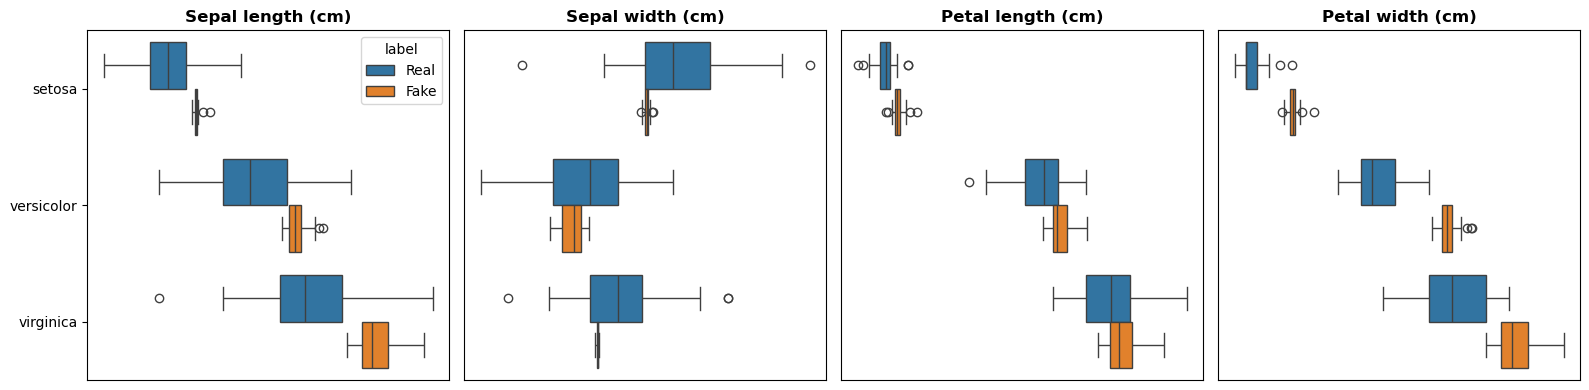

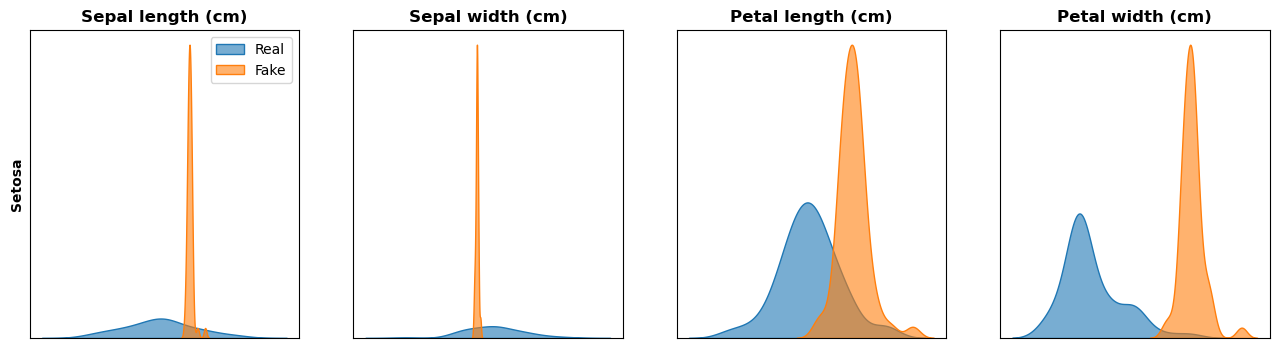

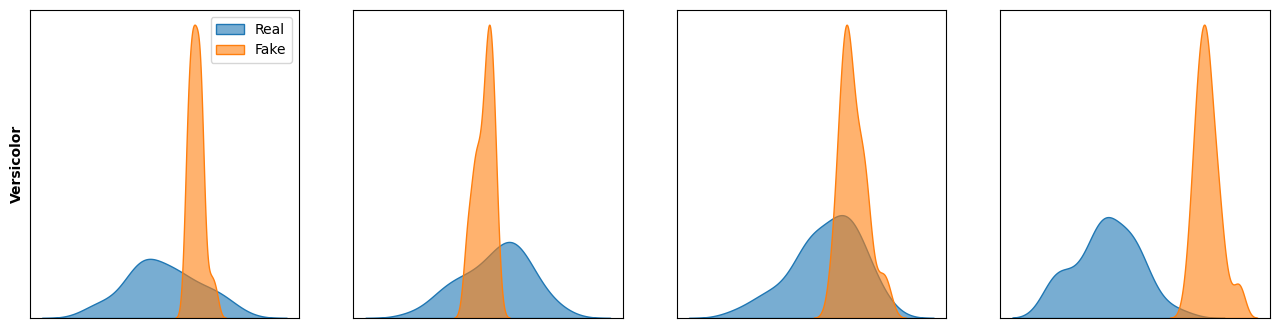

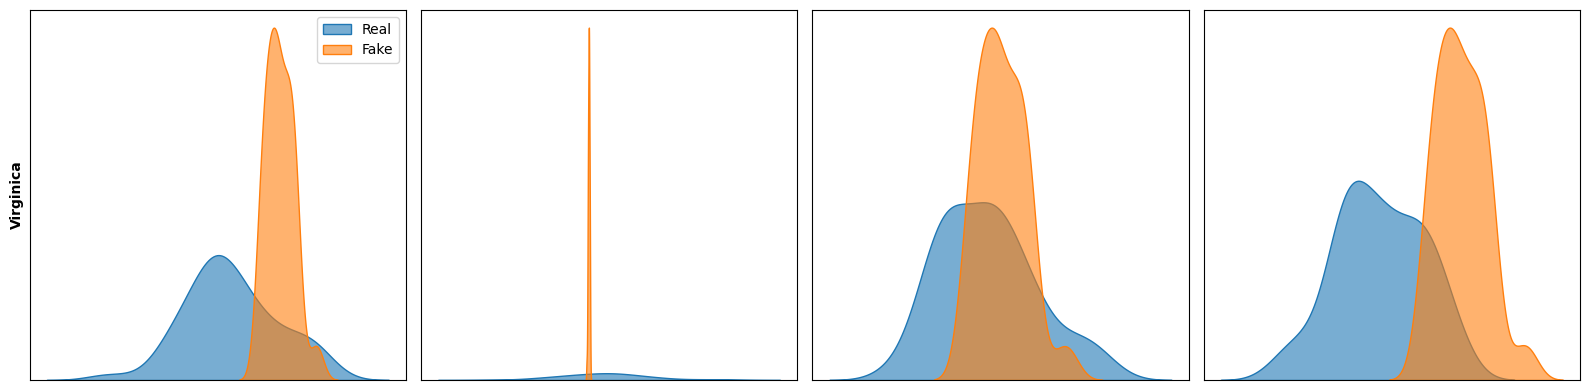

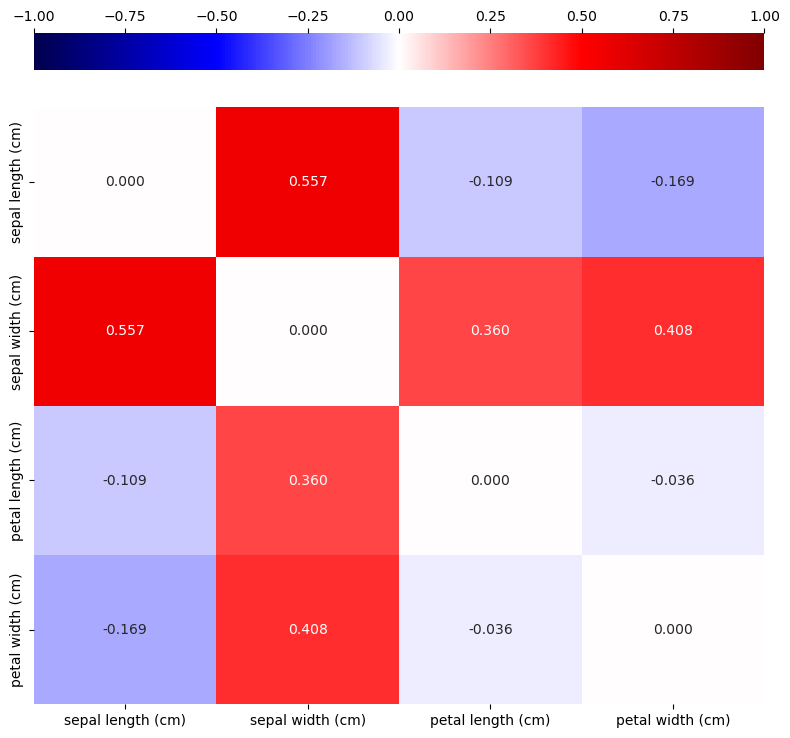

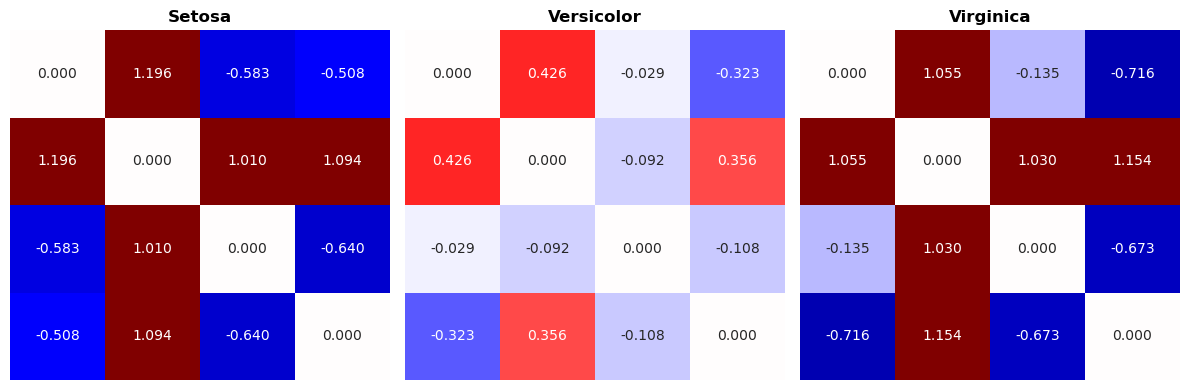

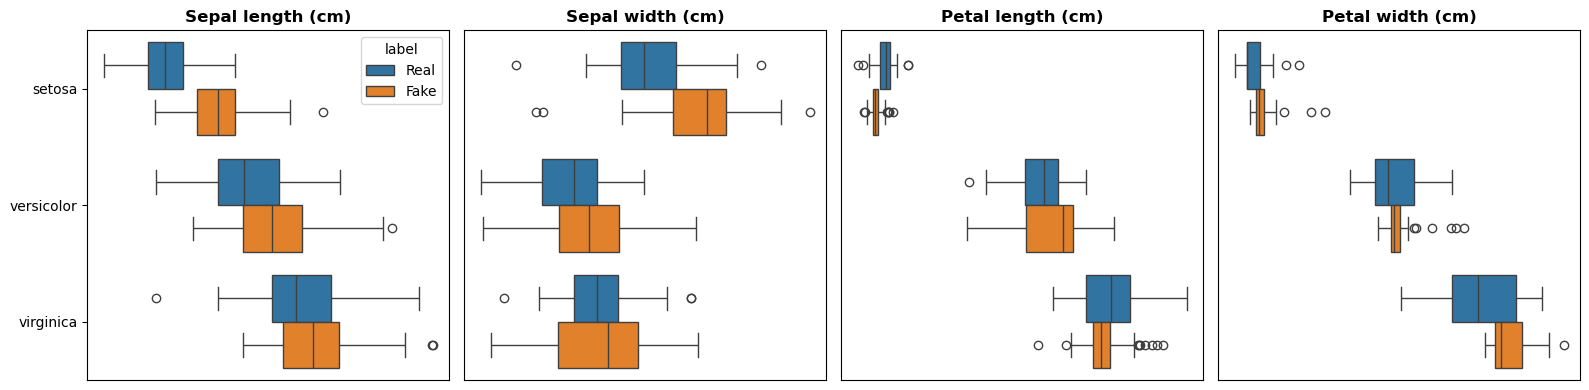

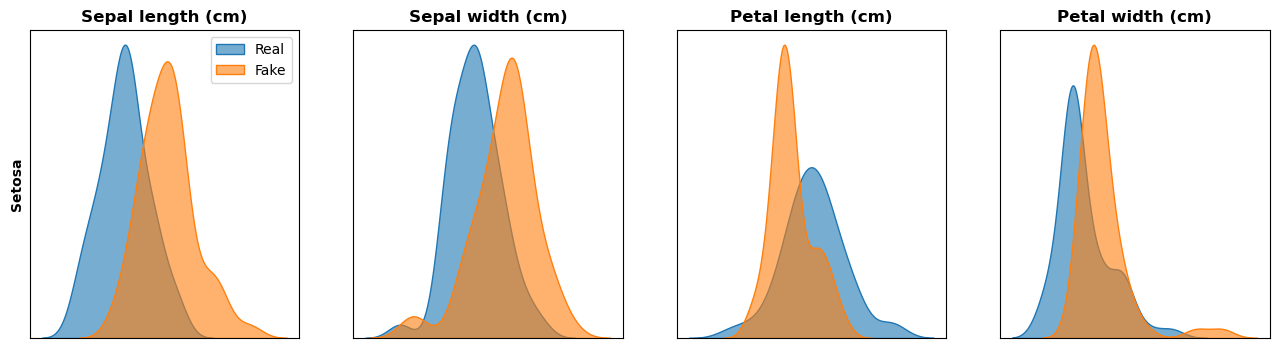

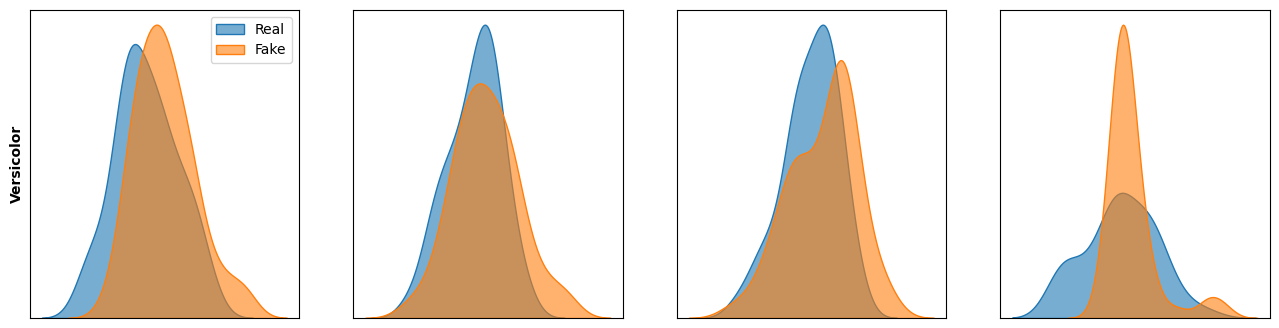

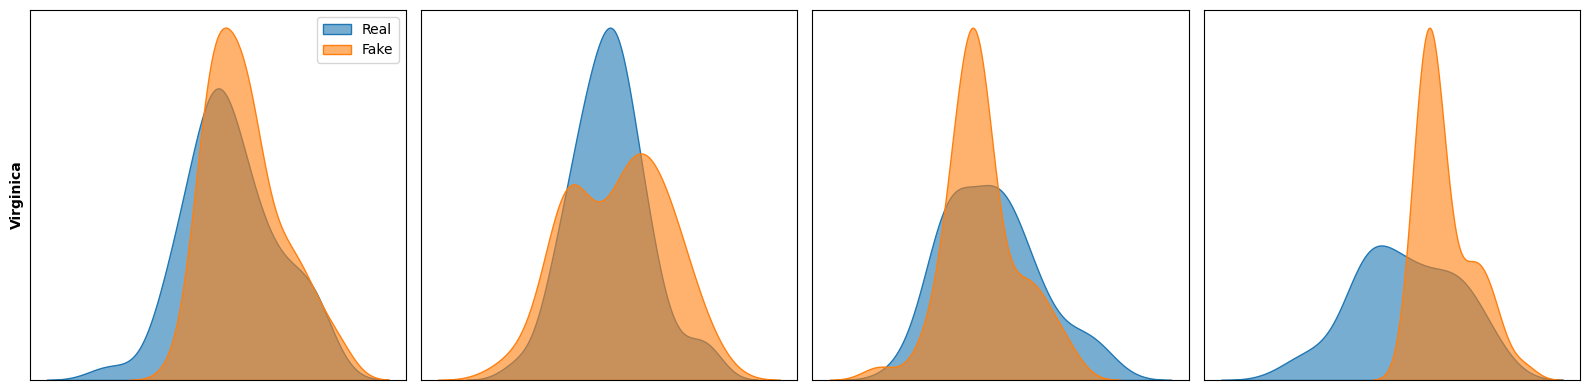

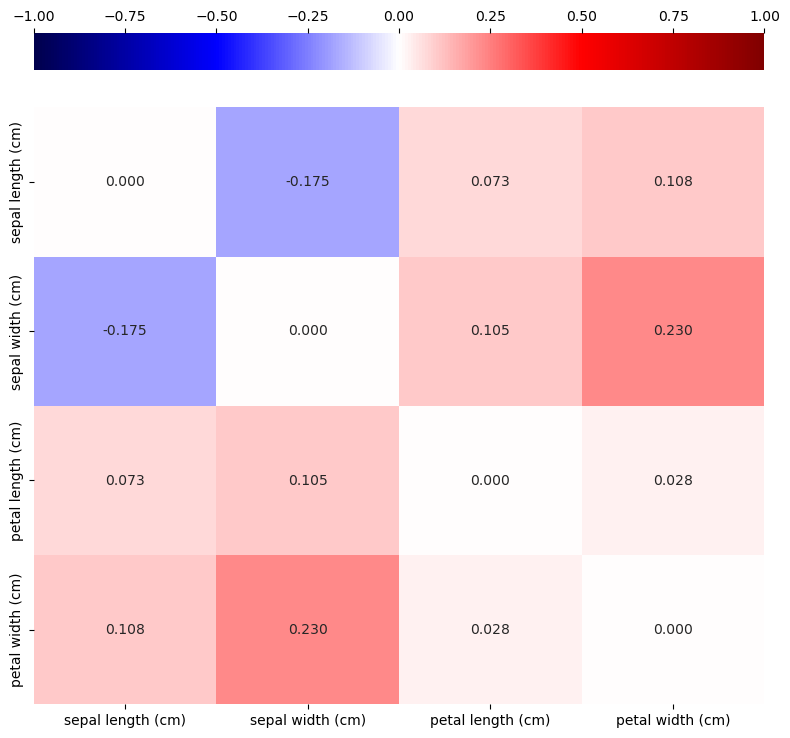

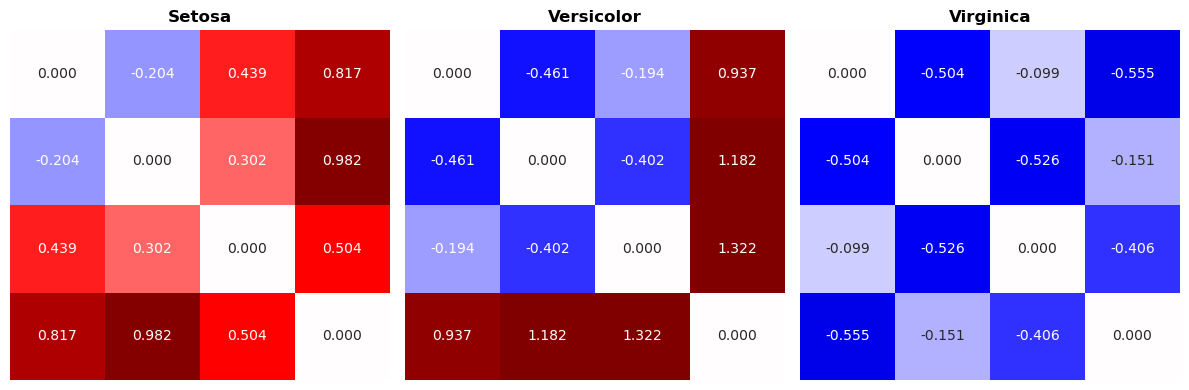

In [32]:
utils.plot_data(real_iris, 'target', gan1_df)
utils.plot_data(real_iris, 'target', gan2_df)
utils.plot_data(real_iris, 'target', gan3_df)

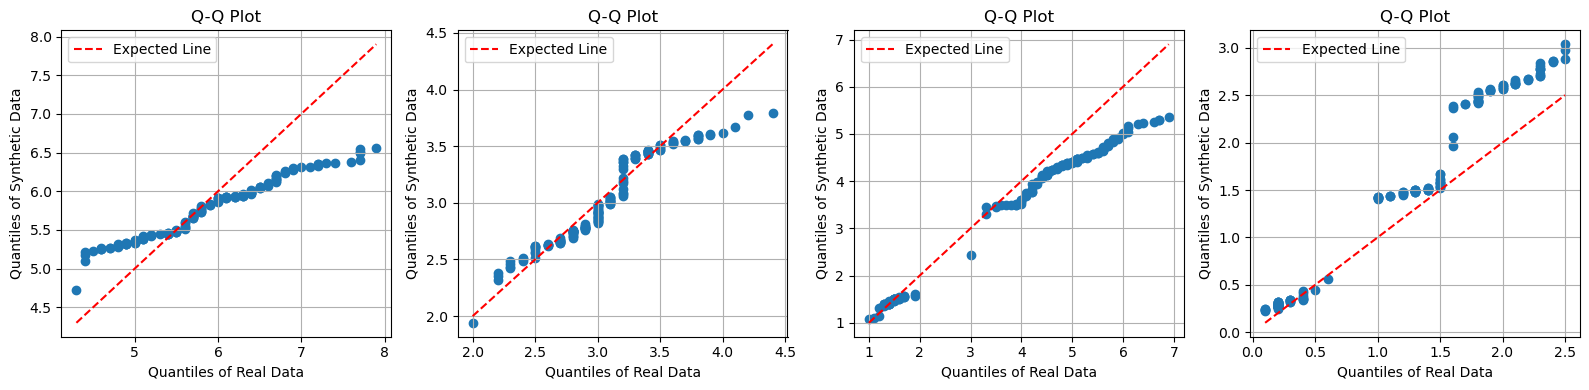

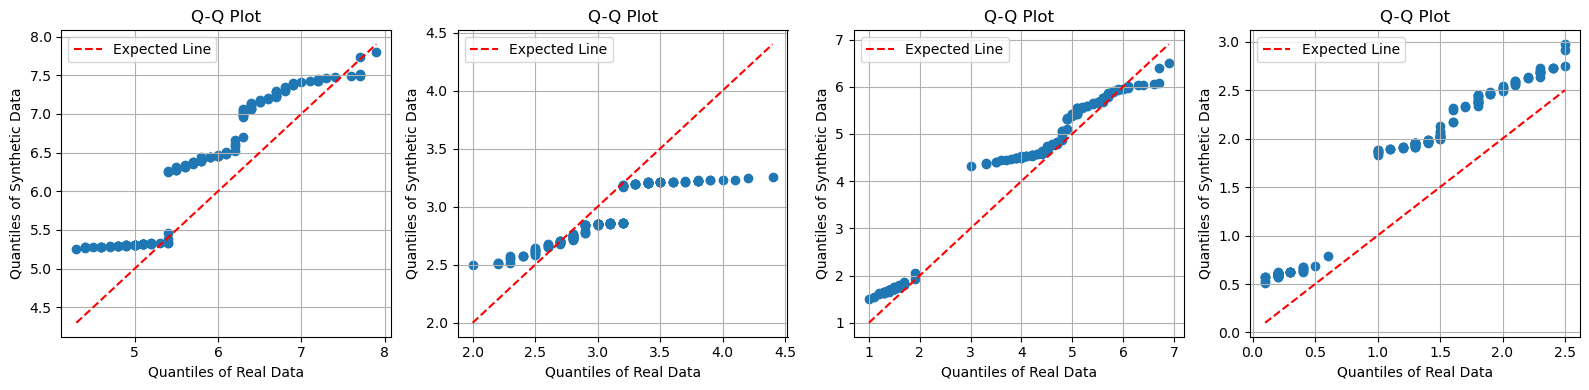

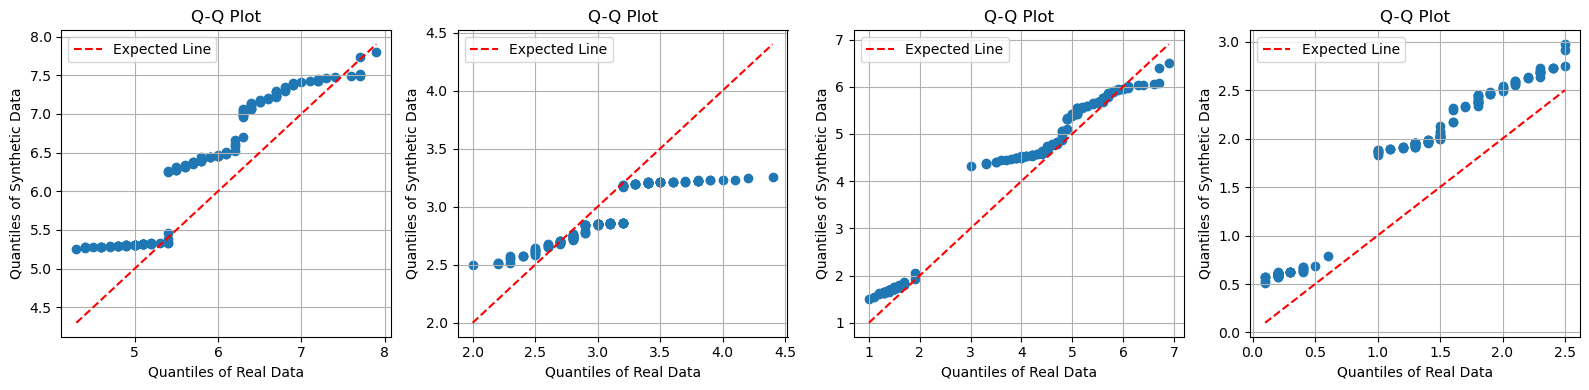

In [33]:
utils.plot_quantiles(real_iris, gan1_df)
utils.plot_quantiles(real_iris, gan2_df)
utils.plot_quantiles(real_iris, gan2_df)

Overall, for the same noise vector size, it is the smaller model that shows the best performance: in fact it produces the smallest differences between the observed and recreated correlations, and in the Q-Q plots we can see how the two distributions tend to overlap more than the other two models. 

We will continue with the fine tuning of this architecture. But first we will look for the best size of the noise vector.

AttributeError: 'float' object has no attribute 'shape'

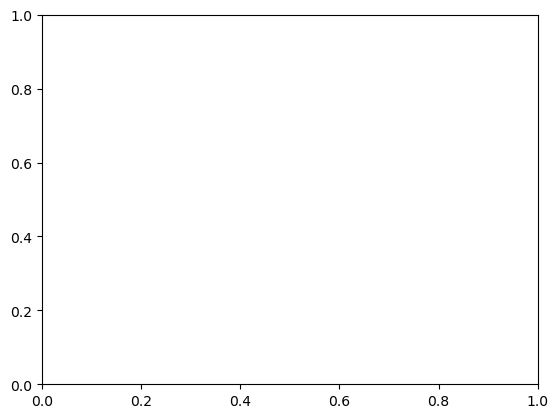

In [39]:
plt.violinplot(data = real_iris[real_iris['target'] == 'versicolor'], x = 'petal')

In [34]:
np.round(real_iris.select_dtypes('number').corr() - gan1_df.select_dtypes('number').corr(), 3).sum().sum()

2.436

In [35]:
np.round(real_iris.select_dtypes('number').corr() - gan2_df.select_dtypes('number').corr(), 3).sum().sum()

2.0220000000000002

In [36]:
np.round(real_iris.select_dtypes('number').corr() - gan3_df.select_dtypes('number').corr(), 3).sum().sum()

0.738